영상에서 텍스트 추출 (OCR 모델)

영상 자료에서 판서나 프레젠테이션 자료가 많이 사용된다면, Tesseract나 Google Vision API 같은 OCR(Optical Character Recognition) 기술을 사용해 텍스트를 추출할 수 있습니다. 이 텍스트는 수학 문제, 개념 설명 등을 분류하는 데 유용할 것입니다.


음성 데이터를 텍스트로 변환 (Speech-to-Text)

강의의 음성을 분석하기 위해 Google Speech-to-Text API나 OpenAI의 Whisper 모델을 사용할 수 있습니다. 음성 데이터를 텍스트로 변환한 후 자연어 처리(NLP)를 통해 주제를 파악할 수 있습니다.


자연어 처리(NLP)를 통한 분류

KoBERT 또는 KoGPT-2 같은 한국어 기반 언어 모델을 사용하여 강의 내용을 분석하고, 교육과정에 맞게 주제 분류를 수행할 수 있습니다.
이때 한국의 수학교육과정을 기반으로 태그를 생성하거나 주제를 설정해, 모델이 각 강의 내용을 적절히 분류할 수 있도록 훈련시키는 것이 중요합니다.

커스텀 분류 모델

수학 강의 영상은 특정한 주제를 중심으로 구성되므로, 이를 위해 BERT 기반의 분류 모델을 커스텀하여 사용할 수 있습니다. 해당 모델을 한국 수학교육과정의 주요 단원 및 하위 단원(예: 함수, 미적분, 기하 등)으로 학습시키면 됩니다.

추천 모델 구조
OCR + Speech-to-Text + KoBERT 분류 모델

영상에서 텍스트와 음성을 추출.

텍스트를 KoBERT와 같은 NLP 모델로 분석.

분석된 데이터를 수학교육과정에 맞춰 분류.

이러한 모델을 구축하면 강의 영상을 효과적으로 분류할 수 있습니다.

In [ ]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
import gluonnlp as nlp
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model
from sklearn.model_selection import train_test_split

# 1. 수학교육과정 카테고리 정의 (예시)
labels = ["숫자", "연산", "도형", "측정", "규칙성", "확률과 통계"]

# 2. 데이터셋 준비 (강의 요약 텍스트와 레이블)
# 예시 데이터셋
data = [
    ("이 문제는 더하기와 빼기 연산을 사용하여 해결합니다.", "연산"),
    ("삼각형의 넓이를 구하는 방법을 설명합니다.", "도형"),
    # ...
]


class MathLectureDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
        )
        input_ids = inputs["input_ids"].squeeze(0)
        attention_mask = inputs["attention_mask"].squeeze(0)
        label = torch.tensor(labels.index(label))
        return input_ids, attention_mask, label


# 3. KoBERT 모델 로드
bert_model, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)


# 4. 분류기 모델 정의
class MathClassifier(nn.Module):
    def __init__(self, bert_model, hidden_size=768, num_classes=len(labels)):
        super(MathClassifier, self).__init__()
        self.bert = bert_model
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.classifier(pooled_output)
        return output


# 5. 데이터 분할 (train/test split)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = MathLectureDataset(train_data, tok)
test_dataset = MathLectureDataset(test_data, tok)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 6. 모델 학습 준비
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MathClassifier(bert_model).to(device)
optimizer = Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()


# 7. 학습 루프
def train_model(model, train_loader, optimizer, loss_fn, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")


# 8. 모델 학습
train_model(model, train_loader, optimizer, loss_fn, device)


# 9. 테스트 (평가)
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


evaluate_model(model, test_loader, device)

In [1]:
import re

# 1. 수학교육과정 카테고리 정의
categories = {
    "수와 연산": [
        "한마리",
        "두마리",
        "세마리",
        "네마리",
        "다섯마리",
        "여섯마리",
        "적다",
        "많다",
        "같다",
        "숫자",
        "비교",
        "크다",
        "작다",
    ],
    "도형": ["삼각형", "사각형", "원", "도형", "모서리", "꼭짓점"],
    "측정": ["길이", "높이", "넓이", "무게", "시간", "측정"],
    "규칙성": ["패턴", "규칙", "반복", "수열"],
    "확률과 통계": ["확률", "데이터", "통계", "그래프"],
}


# 2. 레이블링 함수 정의
def label_text(text):
    label_counts = {category: 0 for category in categories}

    # 각 카테고리별로 해당하는 키워드가 텍스트에 있는지 확인
    for category, keywords in categories.items():
        for keyword in keywords:
            if re.search(keyword, text):
                label_counts[category] += 1

    # 가장 많은 키워드가 포함된 카테고리를 선택
    label = max(label_counts, key=label_counts.get)
    return label


# 3. 예시 텍스트
texts = [
    "Gavin은 한마리, 두마리, 세마리, 네마리, 다섯마리, 여섯마리의 말을 가지고 있습니다.",
    "여기는 삼각형 모양의 그림이 있습니다.",
    "이 박스의 길이와 넓이를 재어보세요.",
    "수열에서 규칙을 찾아보세요.",
    "확률을 계산하여 데이터를 분석하세요.",
]

# 4. 텍스트 레이블링
for text in texts:
    label = label_text(text)
    print(f"텍스트: {text}\n레이블: {label}\n")

텍스트: Gavin은 한마리, 두마리, 세마리, 네마리, 다섯마리, 여섯마리의 말을 가지고 있습니다.
레이블: 수와 연산

텍스트: 여기는 삼각형 모양의 그림이 있습니다.
레이블: 도형

텍스트: 이 박스의 길이와 넓이를 재어보세요.
레이블: 측정

텍스트: 수열에서 규칙을 찾아보세요.
레이블: 규칙성

텍스트: 확률을 계산하여 데이터를 분석하세요.
레이블: 확률과 통계



c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from cu

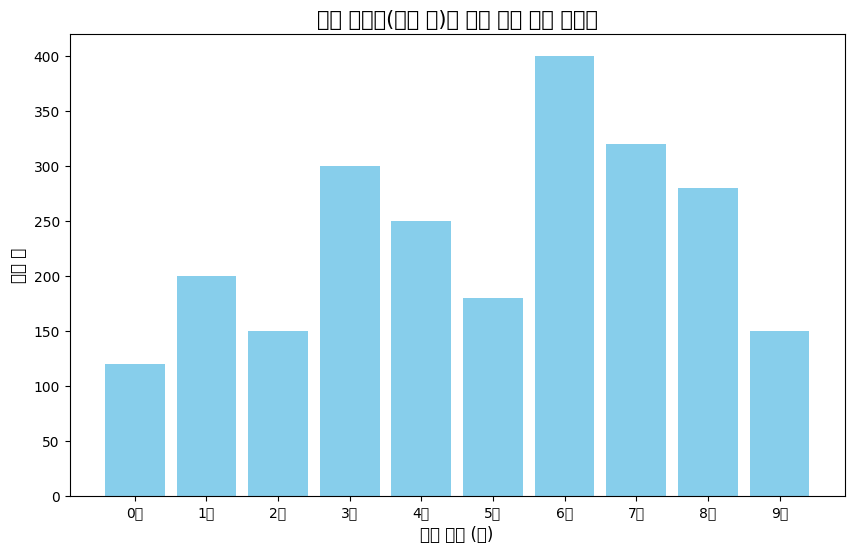

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 예시: 일정 시간 동안 추출된 텍스트
# 여기서는 가상의 데이터를 사용해 일정 시간동안 텍스트가 얼마나 나왔는지 가정합니다.
# 시간은 초 단위로 나열되며 각 시간대에 제공된 단어 수로 정보량을 표시합니다.
time_intervals = np.arange(0, 600, 60)  # 0초에서 600초까지, 1분 간격
word_count_per_interval = [
    120,
    200,
    150,
    300,
    250,
    180,
    400,
    320,
    280,
    150,
]  # 각 시간대에 말한 단어 수

# 2. 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(time_intervals, word_count_per_interval, width=50, color="skyblue")

# 3. 그래프 제목 및 라벨
plt.title("정보 제공량(단어 수)에 따른 강의 시간 시각화", fontsize=15)
plt.xlabel("강의 시간 (초)", fontsize=12)
plt.ylabel("단어 수", fontsize=12)
plt.xticks(time_intervals, labels=[f"{int(t/60)}분" for t in time_intervals])

# 4. 그래프 보여주기
plt.show()

In [8]:
# 필요한 라이브러리 임포트
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 데이터셋 준비
texts = [
    "Lulu가 가방을 싸고 있습니다. 두 그룹으로 5개의 셔츠를 넣었습니다.",
    "다섯 자리 이상의 수를 배워요.",
    "길이를 측정하는 방법을 알아봅니다.",
    "규칙 찾기 문제를 풉니다.",
]
labels = ["곱셈", "수와 연산", "측정", "규칙성"]

# 레이블 인코딩
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# KoBERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")

# 모델 로드 (KoBERT)
model = BertForSequenceClassification.from_pretrained(
    "monologg/kobert", num_labels=len(le.classes_)
)


# 토크나이징 및 데이터셋 생성
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=64,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }


# 학습/검증 데이터 분리
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels_encoded, test_size=0.2
)

# 데이터셋 로드
train_dataset = CustomDataset(train_texts, train_labels)
val_dataset = CustomDataset(val_texts, val_labels)

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


# 옵티마이저와 손실 함수 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# 학습 루프
for epoch in range(3):
    model.train()
    for batch in train_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        outputs = model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels
        )
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed.")

# 검증
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = outputs.logits.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation accuracy: {accuracy * 100:.2f}%")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Validation accuracy: 0.00%


In [1]:
import os
import pandas as pd
import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset


# 사용자 정의 데이터셋 클래스
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }


# 텍스트 파일에서 데이터 읽기
def load_texts_from_files(directory):
    texts = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), "r", encoding="utf-8") as file:
                texts.append(file.read())
    return texts


# 텍스트 파일이 저장된 디렉토리 경로
directory_path = "./khan_text"
texts = load_texts_from_files(directory_path)

# 레이블 생성 (레이블을 숫자로 변환해야 함)
# 예시로 모든 레이블을 0으로 설정
labels = [0] * len(texts)  # 실제 레이블로 변경 필요

# KoBERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")
model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=5)

# 데이터 분할
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.1
)

# 데이터셋 생성
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_len=128)

# 학습 인자 설정
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 모델 학습
trainer.train()

# 모델 평가
trainer.evaluate()

# 모델 저장
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")


# 예측 함수
def predict(texts):
    model.eval()
    inputs = tokenizer(
        texts, return_tensors="pt", padding=True, truncation=True, max_length=128
    )
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return predictions


# 예시 텍스트로 예측
new_texts = ["수학 강의 내용 예시"]
predictions = predict(new_texts)
print(predictions)

c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassif

{'loss': 1.6053, 'grad_norm': 14.124951362609863, 'learning_rate': 1.0000000000000002e-06, 'epoch': 1.0}


 67%|██████▋   | 20/30 [00:24<00:10,  1.08s/it]

{'loss': 1.4546, 'grad_norm': 12.655572891235352, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.0}


100%|██████████| 30/30 [00:37<00:00,  1.09s/it]

{'loss': 1.201, 'grad_norm': 8.842447280883789, 'learning_rate': 3e-06, 'epoch': 3.0}


100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


{'train_runtime': 38.2354, 'train_samples_per_second': 5.885, 'train_steps_per_second': 0.785, 'train_loss': 1.420317045847575, 'epoch': 3.0}


100%|██████████| 2/2 [00:00<00:00, 30.25it/s]


tensor([0])


In [10]:
directory_path = (
    "./khan_text"  # 여기에 텍스트 파일들이 있는 디렉토리 경로를 설정하세요.
)

# 텍스트 파일에서 내용을 읽어와 리스트에 저장
texts = []

for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):  # 파일 확장자가 .txt인 경우
        file_path = os.path.join(directory_path, filename)
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read().strip()
            texts.append(content)

# 예시 출력 (리스트의 첫 번째 텍스트 내용 확인)
print(texts[:3])  # 처음 3개의 텍스트 내용을 확인

["Gavin has these horses. Is the number of horses in each picture below more than, less than, or same as the number of horses Gavin has? So let's first look at how many horses Gavin has. He has one, two, three, four, five, six horses. Okay, so let's remember that. and let's compare each of these amounts of horse.  to the six horses that Gavin has. So let's look over here. So over here, we have one, two, three, four, five, six horses. So this is the same number that Gavin has. They're just arranged differently. So this is the same. We'll put it in the same-as bucket. Now here we have one, two, three, four, five horses. So this is less than the c-  six horses that Gavin has. Five is less than six. Here, and I can just look at this and see that there's more than six, but we can count them. We have one, two, three, four, five, and then another five, that's going to be 10. Or we can say one, two, three, four, five, six, seven, eight, nine, 10. Well, 10 is more than six. 10 is more than six,

In [1]:
files_labels = {
    "Video_ Comparing numbers of objects.txt": ["수", "통계"],
    "Video_ Comparing numbers on the number line.txt": ["수", "그래프"],
    "Video_ Counting by category.txt": ["수", "통계", "그래프"],
    "Video_ Counting in pictures.txt": ["수", "통계"],
    "Video_ Counting objects 1.txt": ["수", "측정"],
    "Video_ Counting objects 2.txt": ["수", "덧셈", "뺄셈", "곱셈", "통계"],
    "y2mate.com - Adding 1 vs adding 10  Addition and subtraction  1st grade  Khan Academy_v720P.txt": [
        "수",
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Adding 5  3  6  Addition and subtraction within 20  Early Math  Khan Academy_720pFH.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Adding 7  6  Addition and subtraction within 20  Early Math  Khan Academy_720pFH.txt": [
        "덧셈",
        "뺄셈",
        "수",
    ],
    "y2mate.com - Adding 8  7  Addition and subtraction within 20  Early Math  Khan Academy_720pFH.txt": [
        "수",
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Adding to 10  Basic addition and subtraction  Early Math  Khan Academy_v720P.txt": [
        "수",
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Adding with arrays_v720P.txt": ["덧셈", "수", "그래프"],
    "y2mate.com - Adding with place value blocks_v720P.txt": ["수", "덧셈"],
    "y2mate.com - Addition and subtraction within 10  Basic addition and subtraction  Early Math  Khan Academy_v720P.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Addition based on arrays word problems_v720P.txt": ["덧셈", "수"],
    "y2mate.com - Addition with 10 frames_v720P.txt": ["덧셈"],
    "y2mate.com - Addition word problems within 10  Basic addition and subtraction  Early Math  Khan Academy_v720P.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Comparing whole numbers  Place value tens and hundreds  Early Math  Khan Academy_v720P.txt": [
        "수"
    ],
    "y2mate.com - Comparison word problems  Addition and subtraction within 20  Early Math  Khan Academy_720pFH.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Comparison word problems rolypolies  Addition and subtraction  1st grade  Khan Academy_v720P.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Constructing a scatter plot  Regression  Probability and Statistics  Khan Academy_720pFH.txt": [
        "그래프",
        "통계",
        "확률",
    ],
    "y2mate.com - Converting repeating decimals to fractions 1  Linear equations  Algebra I  Khan Academy_720pFH.txt": [
        "소수",
        "분수",
        "함수",
        "소수점",
    ],
    "y2mate.com - Coordinate plane plot ordered pairs  Negative numbers  6th grade  Khan Academy_v720P.txt": [
        "수",
        "좌표평면",
        "그리드",
        "음수",
        "그래프",
    ],
    "y2mate.com - Corresponding points and sides of scaled shapes_720pFH.txt": [
        "평면도형",
        "입체도형",
        "도형",
        "비율",
        "비례식",
    ],
    "y2mate.com - Counting by tens  Counting  Early Math  Khan Academy_v720P.txt": [
        "수"
    ],
    "y2mate.com - Counting by tens examples  Addition and subtraction within 100  Early Math  Khan Academy_v720P.txt": [
        "수",
        "덧셈",
        "뺄셈",
        "측정",
    ],
    "y2mate.com - Counting in order  Counting  Early Math  Khan Academy_720pFH.txt": [
        "수",
        "덧셈",
    ],
    "y2mate.com - Counting with small numbers  Counting  Early Math  Khan Academy_720pHF.txt": [
        "수"
    ],
    "y2mate.com - Decomposing angles  Math  4th grade  Khan Academy_v720P.txt": [
        "각도",
        "대칭",
        "수",
    ],
    "y2mate.com - Equal sign  Addition and subtraction within 20  Early Math  Khan Academy_720p.txt": [
        "수",
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Estimating 2 digit multiplication example_v720P.txt": [
        "수",
        "곱셈",
        "측정",
    ],
    "y2mate.com - Examples identifying multiples_v720P.txt": ["약수", "배수"],
    "y2mate.com - Examples relating decimals and fractions in words_v720P.txt": [
        "분수",
        "소수",
    ],
    "y2mate.com - Exercising gorillas  Addition and subtraction within 20  Early Math  Khan Academy_720pFH.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Finding factors of a number  Factors and multiples  PreAlgebra  Khan Academy_720pFH.txt": [
        "수",
        "약수",
        "배수",
    ],
    "y2mate.com - Fractiondecimal intuition problems examples  4th grade  Khan Academy_720pFH.txt": [
        "분수",
        "소수",
        "소수점",
    ],
    "y2mate.com - Getting to 10 by filling boxes  Basic addition and subtraction  Early Math  Khan Academy_v720P.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Greater than and less than symbols  Applying mathematical reasoning  PreAlgebra  Khan Academy_720pFH.txt": [
        "수",
        "도형",
        "비율",
        "함수",
    ],
    "y2mate.com - How to simplify an expression by combining like terms and the distributive property  Khan Academy_720pFH.txt": [
        "수",
        "덧셈",
        "뺄셈",
        "곱셈",
    ],
    "y2mate.com - How to test solutions to equations using substitution  6th grade  Khan Academy_720pFH.txt": [
        "수",
        "비율",
        "비례식",
        "함수",
    ],
    "y2mate.com - Identifying hundredths on a number line  Math  4th grade  Khan Academy_720pFH.txt": [
        "소수",
        "소수점",
        "수",
    ],
    "y2mate.com - Interpreting absolute value as distance  7th grade  Khan Academy_720pFH.txt": [
        "수",
        "비율",
        "함수",
    ],
    "y2mate.com - Introduction to addition  Basic addition and subtraction  Early Math  Khan Academy_720pFH.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Introduction to place value  Place value tens and hundreds  Early Math  Khan Academy_720pFH.txt": [
        "수",
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Introduction to subtraction  Basic addition and subtraction  Early Math  Khan Academy_720pFH.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Making 5  Basic addition and subtraction  Early Math  Khan Academy_720pFH.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Measuring angles with a circular protractor  Math  4th grade  Khan Academy_v720P.txt": [
        "각도",
        "측정",
    ],
    "y2mate.com - Metric system units of distance  4th grade  Khan Academy_720pFH.txt": [
        "측정",
        "길이",
    ],
    "y2mate.com - Metric system units of volume  4th grade  Khan Academy_720pFH.txt": [
        "측정",
        "길이",
        "화폐",
    ],
    "y2mate.com - Metric system units of weight  4th grade  Khan Academy_720pFH.txt": [
        "측정"
    ],
    "y2mate.com - Missing numbers between 0 and 120  Counting  Early Math  Khan Academy_720pFH.txt": [
        "수",
        "덧셈",
        "뺄셈",
        "측정",
    ],
    "y2mate.com - Missing numbers in addition and subtraction  2nd grade  Khan Academy_720pFH.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Monkeys for a party  Place value tens and hundreds  Early Math  Khan Academy_v720P.txt": [
        "수",
        "덧셈",
        "뺄셈",
        "측정",
        "화폐",
        "그래프",
    ],
    "y2mate.com - Multiplying 10s  Math  4th grade  Khan Academy_720pFH.txt": ["곱셈"],
    "y2mate.com - Multiplying 2 digit numbers  Multiplication and division  4th grade  Khan Academy_720pFH.txt": [
        "곱셈",
        "나눗셈",
    ],
    "y2mate.com - Number grid  Counting Early Math Khan Academy_720pFH.txt": [
        "수",
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Pieces of fruit Basic addition and subtraction Early Math Khan Academy_v720P.txt": [
        "덧셈",
        "뺄셈",
        "수",
    ],
    "y2mate.com - Place value example with 25 Place value tens and hundreds Early Math Khan Academy_720pFH.txt": [
        "수",
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Place value example with 42 Place value tens and hundreds Early Math Khan Academy_720pFH.txt": [
        "수",
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Powers of fractions Exponents radicals and scientific notation PreAlgebra Khan Academy_720pFH.txt": [
        "수",
        "분수",
        "곱셈",
        "소수",
        "함수",
    ],
    "y2mate.com - Recognizing prime and composite numbers Factors and multiples PreAlgebra Khan Academy_720pFH.txt": [
        "수",
        "약수",
        "배수",
    ],
    "y2mate.com - Regrouping whole numbers Arithmetic properties PreAlgebra Khan Academy_720pFH.txt": [
        "수",
        "덧셈",
        "뺄셈",
        "곱셈",
        "나눗셈",
    ],
    "y2mate.com - Relating addition and subtraction Basic addition and subtraction Early Math Khan Academy_720pFH.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Repeated addition example Addition and subtraction within 100 Early Math Khan Academy_720pFH.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Representing and comparing rates Linear equations and functions 8th grade Khan Academy_720pFH.txt": [
        "비율",
        "비례식",
        "함수",
        "그래프",
    ],
    "y2mate.com - Rewriting fractions as decimals Math 4th grade Khan Academy_720pFH.txt": [
        "분수",
        "소수",
        "소수점",
    ],
    "y2mate.com - Rounding whole numbers example 2 Arithmetic properties PreAlgebra Khan Academy_v720P.txt": [
        "수",
        "덧셈",
        "뺄셈",
        "곱셈",
        "나눗셈",
    ],
    "y2mate.com - Skip counting by 5 example Addition and subtraction within 100 Early Math Khan Academy_720pFH.txt": [
        "덧셈",
        "뺄셈",
        "수",
    ],
    "y2mate.com - Solving the troll riddle visually Algebra II Khan Academy_720pFH.txt": [
        "수",
        "덧셈",
        "뺄셈",
        "곱셈",
        "나눗셈",
        "분수",
        "소수",
        "소수점",
        "비율",
        "비례식",
        "비",
        "그래프",
        "함수",
    ],
    "y2mate.com - Statistical questions Data and statistics 6th grade Khan Academy_720pFH.txt": [
        "통계",
        "그래프",
        "확률",
    ],
    "y2mate.com - Subtracting 1 vs subtracting 10 Addition and subtraction within 100 2nd grade Khan Academy_v720P.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Subtracting 14 6 Addition and subtraction within 20 Early Math Khan Academy_720pFH.txt": [
        "수",
        "뺄셈",
        "덧셈",
    ],
    "y2mate.com - Subtracting multi digit numbers with regrouping_720pFH.txt": ["뺄셈"],
    "y2mate.com - Subtracting with a number line_v720P.txt": ["뺄셈", "수", "측정"],
    "y2mate.com - Subtraction using place value blocks_v720P.txt": ["뺄셈", "자릿값"],
    "y2mate.com - Subtraction with ten frames_v720P.txt": [
        "뺄셈",
        "수",
        "측정",
        "그래프",
    ],
    "y2mate.com - Subtraction word problems within 10 Basic addition and subtraction Early Math Khan Academy_v720P.txt": [
        "덧셈",
        "뺄셈",
    ],
    "y2mate.com - Teens as sums with 10 Place value tens and hundreds Early Math Khan Academy_v720P.txt": [
        "수",
        "덧셈",
        "측정",
        "화폐",
    ],
    "y2mate.com - Time word problem puzzle Math 3rd grade Khan Academy_v720P.txt": [
        "시간"
    ],
    "y2mate.com - Transformations dilation_720pFH.txt": [
        "도형",
        "평면도형",
        "입체도형",
        "대칭",
    ],
    "y2mate.com - Understanding place value when adding ones Early Math Khan Academy_720pFH.txt": [
        "수",
        "덧셈",
        "소수점",
    ],
    "y2mate.com - Understanding place value when subtracting tens Early Math Khan Academy_v720P.txt": [
        "수",
        "뺄셈",
    ],
    "y2mate.com - Understanding place value while subtracting ones Early Math Khan Academy_v720P.txt": [
        "수",
        "뺄셈",
    ],
    "y2mate.com - Why a negative times a negative is a positive PreAlgebra Khan Academy_720pFH.txt": [
        "곱셈",
        "수",
    ],
}

In [2]:
import os
import pandas as pd

# 텍스트 파일이 저장된 디렉토리 경로
directory = "./khan_text_transed"

# 데이터프레임을 만들기 위한 리스트
data = []

# 파일과 라벨을 반복하면서 데이터프레임 리스트를 생성
for filename, labels in files_labels.items():
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()
            data.append(
                {"filename": filename, "text": content, "label": ", ".join(labels)}
            )
    else:
        print(f"파일 {filename}이(가) 디렉토리에 존재하지 않습니다.")

# 데이터프레임 생성
data = pd.DataFrame(data)

# 데이터프레임 확인
print(data.head())

파일 y2mate.com - Number grid  Counting Early Math Khan Academy_720pFH.txt이(가) 디렉토리에 존재하지 않습니다.
파일 y2mate.com - Pieces of fruit Basic addition and subtraction Early Math Khan Academy_v720P.txt이(가) 디렉토리에 존재하지 않습니다.
파일 y2mate.com - Place value example with 25 Place value tens and hundreds Early Math Khan Academy_720pFH.txt이(가) 디렉토리에 존재하지 않습니다.
파일 y2mate.com - Place value example with 42 Place value tens and hundreds Early Math Khan Academy_720pFH.txt이(가) 디렉토리에 존재하지 않습니다.
파일 y2mate.com - Powers of fractions Exponents radicals and scientific notation PreAlgebra Khan Academy_720pFH.txt이(가) 디렉토리에 존재하지 않습니다.
파일 y2mate.com - Recognizing prime and composite numbers Factors and multiples PreAlgebra Khan Academy_720pFH.txt이(가) 디렉토리에 존재하지 않습니다.
파일 y2mate.com - Regrouping whole numbers Arithmetic properties PreAlgebra Khan Academy_720pFH.txt이(가) 디렉토리에 존재하지 않습니다.
파일 y2mate.com - Relating addition and subtraction Basic addition and subtraction Early Math Khan Academy_720pFH.txt이(가) 디렉토리에 존재하지 않습니다.
파일 

In [3]:
data.shape

(59, 3)

In [4]:
import pandas as pd

df = pd.DataFrame()

In [5]:
df["name"] = files_labels.keys()
df["태그"] = files_labels.values()

In [6]:
df

,name,태그
0,Video_ Comparing numbers of objects.txt,"[수, 통계]"
1,Video_ Comparing numbers on the number line.txt,"[수, 그래프]"
2,Video_ Counting by category.txt,"[수, 통계, 그래프]"
3,Video_ Counting in pictures.txt,"[수, 통계]"
4,Video_ Counting objects 1.txt,"[수, 측정]"
...,...,...
79,y2mate.com - Transformations dilation_720pFH.txt,"[도형, 평면도형, 입체도형, 대칭]"
80,y2mate.com - Understanding place value when ad...,"[수, 덧셈, 소수점]"
81,y2mate.com - Understanding place value when su...,"[수, 뺄셈]"
82,y2mate.com - Understanding place value while s...,"[수, 뺄셈]"


In [7]:
df["name"] = df["name"].str.replace(" ", "")

In [8]:
df

,name,태그
0,Video_Comparingnumbersofobjects.txt,"[수, 통계]"
1,Video_Comparingnumbersonthenumberline.txt,"[수, 그래프]"
2,Video_Countingbycategory.txt,"[수, 통계, 그래프]"
3,Video_Countinginpictures.txt,"[수, 통계]"
4,Video_Countingobjects1.txt,"[수, 측정]"
...,...,...
79,y2mate.com-Transformationsdilation_720pFH.txt,"[도형, 평면도형, 입체도형, 대칭]"
80,y2mate.com-Understandingplacevaluewhenaddingon...,"[수, 덧셈, 소수점]"
81,y2mate.com-Understandingplacevaluewhensubtract...,"[수, 뺄셈]"
82,y2mate.com-Understandingplacevaluewhilesubtrac...,"[수, 뺄셈]"


In [15]:
df.to_csv("model_train.csv", index=False, encoding="utf-8")

In [9]:
# 텍스트 파일이 저장된 폴더 경로
folder_path = "./khan_text_transed"  # 예: '/path/to/folder'

# 텍스트 파일 내용을 저장할 새로운 열 추가
df["content"] = ""

# 폴더의 모든 파일 목록을 가져오고, 파일 이름에서 띄어쓰기 제거
folder_files = {
    f.replace(" ", ""): f for f in os.listdir(folder_path) if f.endswith(".txt")
}

# 데이터프레임 순회
for index, row in df.iterrows():
    file_name = row["name"].replace(" ", "")  # 데이터프레임의 name에서 띄어쓰기 제거
    if file_name in folder_files:  # 폴더 파일 중 일치하는 파일 찾기
        file_path = os.path.join(folder_path, folder_files[file_name])

        # 파일 내용을 읽어서 추가
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()
        df.at[index, "content"] = content
    else:
        print(f"파일 {row['name']}을(를) 찾을 수 없습니다.")

# 결과 출력
print(df)

                                                 name                    태그  \
0                 Video_Comparingnumbersofobjects.txt               [수, 통계]   
1           Video_Comparingnumbersonthenumberline.txt              [수, 그래프]   
2                        Video_Countingbycategory.txt          [수, 통계, 그래프]   
3                        Video_Countinginpictures.txt               [수, 통계]   
4                          Video_Countingobjects1.txt               [수, 측정]   
..                                                ...                   ...   
79      y2mate.com-Transformationsdilation_720pFH.txt  [도형, 평면도형, 입체도형, 대칭]   
80  y2mate.com-Understandingplacevaluewhenaddingon...          [수, 덧셈, 소수점]   
81  y2mate.com-Understandingplacevaluewhensubtract...               [수, 뺄셈]   
82  y2mate.com-Understandingplacevaluewhilesubtrac...               [수, 뺄셈]   
83  y2mate.com-Whyanegativetimesanegativeisapositi...               [곱셈, 수]   

                                              conte

In [10]:
df

,name,태그,content
0,Video_Comparingnumbersofobjects.txt,"[수, 통계]",이 텍스트를 한국어로 번역: \n\nGavin은 이런 말들이 있습니다. 아래의 각 ...
1,Video_Comparingnumbersonthenumberline.txt,"[수, 그래프]",어떤 숫자들이 6보다 큰가요? 모두 선택해 보세요. 그래서 여기 수직선에서 6을 볼...
2,Video_Countingbycategory.txt,"[수, 통계, 그래프]","우리는 별, 숫자, 또는 글자를 가장 많이 세어 봅시다. 이것을 한 번 보겠습니다...."
3,Video_Countinginpictures.txt,"[수, 통계]","이 사진에 얼마나 많은 사람들이 보이나요? 보세요, 저는 하나, 둘, 셋, 넷, 다..."
4,Video_Countingobjects1.txt,"[수, 측정]","어떤 상자에 12마리의 고래가 있는지요? 그래, 이런 이 녹색 상자를 보세요, 한번..."
...,...,...,...
79,y2mate.com-Transformationsdilation_720pFH.txt,"[도형, 평면도형, 입체도형, 대칭]",이전 비디오에서 우리는 변형에 대한 아이디어를 이야기하기 시작했습니다. 특히 우리는...
80,y2mate.com-Understandingplacevaluewhenaddingon...,"[수, 덧셈, 소수점]",그래서 이 것이 바로 소수 37을 표현하는 한 가지 방법입니다. 숫자 37에는 십의...
81,y2mate.com-Understandingplacevaluewhensubtract...,"[수, 뺄셈]","여기에는 65개의 블록이 있습니다. 직접 세어보실 수도 있지만, 우리는 이를 숫자 ..."
82,y2mate.com-Understandingplacevaluewhilesubtrac...,"[수, 뺄셈]",그래서 바로 여기에 우리는 숫자 46을 가지고 있습니다. 십의 자리에는 4가 있습니...


In [42]:
df = df.drop(columns=["text"])

In [24]:
import os

# 텍스트 파일이 저장된 폴더 경로
folder_path = "./khan_text_transed"  # 예: '/path/to/folder'

# 딕셔너리 예시 (파일명)
file_dict = files_labels

# 폴더의 파일 목록을 가져오고 띄어쓰기 제거
folder_files = [
    f.replace(" ", "") for f in os.listdir(folder_path) if f.endswith(".txt")
]

# 딕셔너리 키 목록 가져오기 (파일명)
dict_files = [key.replace(" ", "") for key in file_dict.keys()]

# 폴더에 없는 파일 찾기 (딕셔너리 키에 있는 파일 중 폴더에 없는 파일)
missing_files = set(folder_files) - set(dict_files)

# 결과 출력
if missing_files:
    print("빠진 파일 목록:", missing_files)
else:
    print("모든 파일이 폴더에 존재합니다.")

빠진 파일 목록: {'y2mate.com-Adding536Additionandsubtractionwithin20EarlyMathKhanAcademy_720pFH.txt'}


In [6]:
import os
import pandas as pd

# 예시 데이터프레임

# 텍스트 파일이 저장된 폴더 경로
folder_path = "./khan_text_transed"  # 예: '/path/to/folder'

# 텍스트 파일 내용을 저장할 새로운 열 추가
df["text"] = ""

# 데이터프레임 순회
for index, row in df.iterrows():
    file_name = row["name"]
    file_path = os.path.join(folder_path, file_name)

    # 파일이 존재하면 내용 읽어서 추가
    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as file:
            content = file.read()
        df.at[index, "content"] = content
    else:
        print(f"파일 {file_name}을(를) 찾을 수 없습니다.")

# 결과 출력
print(df)

NameError: name 'df' is not defined

In [45]:
# 허용된 태그 리스트
allowed_tags = [
    "수",
    "덧셈",
    "뺄셈",
    "곱셈",
    "나눗셈",
    "분수",
    "소수",
    "소수점",
    "길이",
    "시간",
    "화폐",
    "측정",
    "각도",
    "평면도형",
    "입체도형",
    "도형",
    "대칭",
    "원",
    "직각",
    "비율",
    "비례식",
    "비",
    "그래프",
    "통계",
    "확률",
    "약수",
    "배수",
    "함수",
]

# 태그 리스트에서 허용되지 않은 단어를 제거
df["태그"] = df["태그"].apply(lambda tags: [tag for tag in tags if tag in allowed_tags])

# 결과 출력
print(df["태그"])

0                  [수, 통계]
1                 [수, 그래프]
2             [수, 통계, 그래프]
3                  [수, 통계]
4                  [수, 측정]
              ...         
79    [도형, 평면도형, 입체도형, 대칭]
80            [수, 덧셈, 소수점]
81                 [수, 뺄셈]
82                 [수, 뺄셈]
83                 [곱셈, 수]
Name: 태그, Length: 84, dtype: object


In [47]:
# 태그와 숫자를 매핑하는 딕셔너리 생성
tag_to_index = {tag: idx for idx, tag in enumerate(allowed_tags)}


# 태그를 숫자로 변환하는 함수
def tags_to_numbers(tags):
    return [tag_to_index[tag] for tag in tags if tag in tag_to_index]


# '태그' 열의 태그를 숫자로 변환
df["태그"] = df["태그"].apply(tags_to_numbers)

# 결과 출력
print(df)

                                                 name                태그  \
0             Video_ Comparing numbers of objects.txt           [0, 23]   
1     Video_ Comparing numbers on the number line.txt           [0, 22]   
2                     Video_ Counting by category.txt       [0, 23, 22]   
3                     Video_ Counting in pictures.txt           [0, 23]   
4                       Video_ Counting objects 1.txt           [0, 11]   
..                                                ...               ...   
79   y2mate.com - Transformations dilation_720pFH.txt  [15, 13, 14, 16]   
80  y2mate.com - Understanding place value when ad...         [0, 1, 7]   
81  y2mate.com - Understanding place value when su...            [0, 2]   
82  y2mate.com - Understanding place value while s...            [0, 2]   
83  y2mate.com - Why a negative times a negative i...            [3, 0]   

                                              content  
0   이 텍스트를 한국어로 번역: \n\nGavin은 이런 말들이 있습니다.

In [49]:
df.to_csv("khan_df.csv", index=False, encoding="utf-8")

In [11]:
import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset


# 사용자 정의 데이터셋 클래스
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }


# KoBERT 토크나이저 및 모델 로드
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")
model = BertForSequenceClassification.from_pretrained("monologg/kobert", num_labels=4)

# 데이터 분할
texts = df["text"].tolist()
labels = df["label"].tolist()
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2
)

# 데이터셋 생성
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer, max_len=128)

# 학습 인자 설정
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Trainer 객체 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 모델 학습
trainer.train()

# 모델 평가
trainer.evaluate()

# # 모델 저장
# model.save_pretrained("saved_model")
# tokenizer.save_pretrained("saved_model")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|      

TypeError: new(): invalid data type 'str'

In [9]:
def predict(texts):
    model.eval()
    inputs = tokenizer(
        texts, return_tensors="pt", padding=True, truncation=True, max_length=128
    )
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return predictions


# 예시 텍스트로 예측
new_texts = ["5곱하기 6은 얼마일까요"]
predictions = predict(new_texts)
print(predictions)

tensor([1])


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

labels = df["label"].unique()
label2id = {label: idx for idx, label in enumerate(labels)}
df["label"] = df["label"].map(label2id)

# 학습, 검증 데이터 분리
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# KoBERT 토크나이저 로드 (KoBERTTokenizer로 변경)
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("monologg/kobert")


# 데이터셋 클래스 정의
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }


# 데이터로더 설정
train_dataset = TextDataset(
    train_df["text"].values, train_df["label"].values, tokenizer, max_len=128
)
val_dataset = TextDataset(
    val_df["text"].values, val_df["label"].values, tokenizer, max_len=128
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [20]:
from transformers import BertForSequenceClassification, AdamW
from torch.optim import Adam

# 모델 로드
model = BertForSequenceClassification.from_pretrained(
    "monologg/kobert", num_labels=len(labels)
)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=1e-5)


# 학습 함수 정의
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)


# 검증 함수 정의
def eval_epoch(model, data_loader, device):
    model = model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(data_loader)


# 학습 및 검증
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

for epoch in range(3):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = eval_epoch(model, val_loader, device)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss}, Val Loss = {val_loss}")


# # 모델 저장
# model.save_pretrained("saved_model")
# tokenizer.save_pretrained("saved_model")


def predict(texts):
    model.eval()
    inputs = tokenizer(
        texts, return_tensors="pt", padding=True, truncation=True, max_length=128
    )
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    return predictions


# 예시 텍스트로 예측
new_texts = "당신이 고대 철학자이며, 수학을 처음부터 쌓아가고 있다고 가정합시다. 부정수가 무엇을 의미하거나 의미해야 하는지에 대한 합당한 이해가 있고, 또한 부정수를 더하거나 빼는 방법을 알고 있지만, 이제 당신은 혼란에 빠집니다. 부정수를 곱하면 어떻게 될까요? 예를 들어, 양수를 부정수로 곱하거나 또는 두 개의 부정수를 곱하면 어떻게 될까요? 그래서 예를 들어, 양수와 부정수 중 하나를 선택해서 곱하면 어떻게 될지 아직 확실히 모른다고 합시다. 당신이 만약 5와 -3을 곱하면 어떻게 될까요? 당신은 아직 이에 대해 확실하지 않습니다. 또한 두 부정수를 곱하면 어떻게 될지에 대해서도 확실하지 않습니다. 그러니까, -2와 -6을 곱한다고 해봅시다. 이것 역시 당신에게는 불분명합니다. 그러나 당신이 수학자이기 때문에 아는 것은, 어떻게 이를 정의하든, 이것은 당신이 이미 알고 있는 수학의 모든 다른 속성들과 일관되어야 하며, 특히 모든 곱셈의 다른 속성들과 일관되어야 하는 것입니다. 이것은 당신이 이를 올바르게 이해하고 있는 것에 대해 편안함을 느끼게 할 것입니다. 그리고 나중에 우리는 이것들이 무엇이며 실제로 왜 의미있는지에 대한 직관을 얻기 위한 다른 방법에 대해 생각해볼 수 있습니다. 그러나 당신이 이미 알고 있는 수학의 나머지 부분과 일관되게 하기 위해서, 당신은 약간의 사고실험에 들어갑니다. 당신은 말합니다, 5와 3 더하기 -3은 어떻게 될까요? 당신은 이미 부정수를 더하거나 양수를 부정수에 더하는 것에 대한 필승철학을 가지고 있습니다. 당신은 -3이 3의 반대라는 것을 알고 있습니다. 만약 당신이 3을 -3에 더하면, 당신은 0을 얻게 됩니다. 그러므로 이것은, 이것은 5와 0을 곱한 것과 같을 것이며, 5와 0을 곱한 것은, 당신이 이미 양수에 부정수를 더하는 방법에 대해 생각한 것에 기초하여, 그리고 아무 것도 0으로 곱하면 0이 될 것입니다. 그래서 여기의 표현식은 0이어야 합니다. 반면에, 당신은 말합니다, 나는... 그러나 나는 양수와 부정수를 곱하는 것이 분배법칙과 일관되기를 원한다. 그래서 나는 이 5를 분배할 수 있어야 합니다. 나는 이 5를 분배해야 하고, 수학이 일관되게 하려면, 나는 정확히 같은 답을 얻어야 합니다. 그럼 이 5를 분배해봅시다. 그러면 5와 3을 곱하면, 그건 5와 3을 곱한 것, 그러니까 5와 3을 곱하게 되니까, 나는 그것을 곱셈이 아닌 곱셈으로 쓸 것입니다. 곱셈 부호 대신 X를 써서 곱하겠습니다. 5와  곱하기를 분배했으니까, 더하기, 그리고 5와 -3을 곱한 것입니다. 이를 노란색으로 그려주겠습니다. 5와 -3을 곱한 것입니다. 그리고 이 전체적인 것은 우리가 막 얘기했다시피, 이것은 0과 같아야 합니다. 이것은 반드시 0과 같아야 합니다. 그런데 5와 3, 그것들은 두 개의 양수입니다. 그것이 무엇이어야 하는지 우리는 알고 있습니다. 그것을 15로 만들 것입니다. 그러면 이제 우리는 이것을 얻게 됩니다. 그것을 15, 그리고 아무라도 5와 -3을 곱한 것에 더해야 합니다. 그것은 0과 일치하기 위해 필요한 것입니다. 그러면, 15를 더하면 0가 될 것이란 무엇일까요? 15의 반대입니다. 이것이 사실이, 이것이 우리가 알고 있는 다른 수학 전체와 일관되기 위해서, 이 오른쪽의 것은 -15와 같아야 합니다. 그러므로 당신은 5와 -3을 곱한 것은, 우리가 알고 있는 다른 모든 수학과 일관성을 유지하기 위해서, 이것이 -15와 같아야 합니다. 그리고 이것은 또한 -3을 반복해서 5번 더하는 직관과도 일관성이 있습니다. 이제, 두 개의 부정수를 곱하는 것은 약간 더 이해하기 힘든 개념입니다. 그러나 우리는 같은 사고실험을 할 수 있습니다. 우리는 이 답이 우리가 알고 있는 나머지 수학과 일관되게 하길 원합니다. 그래서 우리는 같은 사고실험을 할 수 있습니다. -2와 6... 그리고 -6을 더하면 어떻게 될까요? 6 더하기 -6은 0이 됩니다. -2와 0을 곱하면, 아무 것도 0과 곱하면 0이 됩니다. 그리고 다시, 우리는 분배할 수 있습니다. -2와 6을 곱하면 분배할 수 있습니다. 그래서 우리는 -2, -2와 6을 곱하면 얻게 되고, 더하기, 더하기 -2와 -6을 곱하게 됩니다, 그리고 -2와 -6을 곱하게 됩니다. 그리고 또한, 우린 사실  이것들 모두가 0과 일치해야 합니다. 이제 우리가 갓 제시한 사고 실험을 기준으로, 우리는 말했습니다, 이것은 -12와 같아야 합니다. 또는 우리는 이것을 숫자선에 있는 6을 두 번 왼쪽 방향으로 가는 것으로 볼 수 있고, 이것은 우리에게 -12를 가져다 줍니다. 또는 당신은 -2를 반복해서 6번 더하는 것을 말할 수 있습니다. 그것도 당신을 -12로 데려갈 것입니다. 그리고 이제 우리는 또한 여기에서 보았습니다, 우리가 양수와 부정수를 곱했을 때, 우리는 부정수를 얻었습니다. 그래서 이것이 될 수 있습니다... 또는 우리는 이것이 -12와 같을 것이라는 것을 안다고 말합니다. 그래서 우리는 -12를 얻었습니다. 그리고 더하기, 이 비즈니스를 더하게 됩니다, 이 비즈니스를 더하면, 이것은 반드시 0과 같아야 합니다. 이것은 반드시 0과 같아야 하는데, 그것이 바로 우리가 알고 있는 수학의 나머지 부분과 일관성을 유지하기 위한 것입니다. 그러면, -12에 더하면 0가 될 것이란 무엇일까요? 12 더하기 -12는 0이 됩니다. 그래서 이것이 12와 같아야 하며, 이것은 다른  수학 전부와 일관성을 유지하기 위한 것입니다. 그래서 우리는 이것이 양의 12, 양의 12가 되는 아이디어를 얻게 됩니다. 그것에서 아니라, 나는 당신이 왜 이것들이 사실인지에 대한 개념적 이해를 주기 위해 몇 가지 다른 비디오를 만들 수 있는지 볼 수 있을 것입니다."
predictions = predict(new_texts)
print(predictions)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train Loss = 3.623812437057495, Val Loss = 3.581576108932495
Epoch 2: Train Loss = 3.5548842350641885, Val Loss = 3.610577344894409
Epoch 3: Train Loss = 3.5080726544062295, Val Loss = 3.7943073511123657
tensor([9])


In [38]:
data.shape

(58, 3)

In [36]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from sklearn.model_selection import train_test_split
import torch

# 데이터 전처리
tokenizer = BertTokenizer.from_pretrained("kykim/bert-kor-base")
model = BertForSequenceClassification.from_pretrained(
    "kykim/bert-kor-base", num_labels=5
)

# 데이터셋 준비
data["label"] = data["label"].astype("category").cat.codes
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["text"], data["label"], test_size=0.2
)

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

# 모델 훈련
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

# 모델 저장
model.save_pretrained("./video_classification_model")
tokenizer.save_pretrained("./video_classification_tokenizer")

c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


IndexError: Target 18 is out of bounds.

In [39]:
# 레이블을 카테고리로 변환하고, 숫자로 인코딩
data["label"] = data["label"].astype("category").cat.codes

# 레이블의 범위 확인
num_labels = len(data["label"].unique())
print(f"Number of labels: {num_labels}")

Number of labels: 40


In [40]:
from transformers import BertTokenizer, BertForSequenceClassification

num_labels = len(data["label"].unique())

tokenizer = BertTokenizer.from_pretrained("kykim/bert-kor-base")
model = BertForSequenceClassification.from_pretrained(
    "kykim/bert-kor-base", num_labels=num_labels
)

c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 데이터셋 준비
data["label"] = data["label"].astype("category").cat.codes
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data["text"], data["label"], test_size=0.2
)

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

In [43]:
from transformers import BertForSequenceClassification, BertTokenizer

# 모델과 토크나이저 로드
model = BertForSequenceClassification.from_pretrained(
    "kykim/bert-kor-base", num_labels=num_labels
)
tokenizer = BertTokenizer.from_pretrained("kykim/bert-kor-base")


# 텐서 연속성 문제를 피하기 위한 함수
def make_contiguous(module):
    for name, param in module.named_parameters():
        if not param.is_contiguous():
            param.data = param.data.contiguous()


# 모델의 모든 파라미터를 연속적으로 변환
make_contiguous(model)

# 모델 저장
model.save_pretrained("./video_classification_model")
tokenizer.save_pretrained("./video_classification_tokenizer")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at kykim/bert-kor-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('./video_classification_tokenizer\\tokenizer_config.json',
 './video_classification_tokenizer\\special_tokens_map.json',
 './video_classification_tokenizer\\vocab.txt',
 './video_classification_tokenizer\\added_tokens.json')

In [41]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # 레이블을 torch.long으로 변환
        item["labels"] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [44]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()


100%|██████████| 18/18 [01:50<00:00,  6.15s/it]

{'train_runtime': 110.6674, 'train_samples_per_second': 1.247, 'train_steps_per_second': 0.163, 'train_loss': 3.626617431640625, 'epoch': 3.0}


TrainOutput(global_step=18, training_loss=3.626617431640625, metrics={'train_runtime': 110.6674, 'train_samples_per_second': 1.247, 'train_steps_per_second': 0.163, 'total_flos': 36321713897472.0, 'train_loss': 3.626617431640625, 'epoch': 3.0})

In [45]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# 모델 로드
model = BertForSequenceClassification.from_pretrained("./video_classification_model")
tokenizer = BertTokenizer.from_pretrained("./video_classification_tokenizer")


def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=-1)
    return predicted_class_id.item()


# 예측
text = "당신이 고대 철학자이며, 수학을 처음부터 쌓아가고 있다고 가정합시다. 부정수가 무엇을 의미하거나 의미해야 하는지에 대한 합당한 이해가 있고, 또한 부정수를 더하거나 빼는 방법을 알고 있지만, 이제 당신은 혼란에 빠집니다. 부정수를 곱하면 어떻게 될까요? 예를 들어, 양수를 부정수로 곱하거나 또는 두 개의 부정수를 곱하면 어떻게 될까요? 그래서 예를 들어, 양수와 부정수 중 하나를 선택해서 곱하면 어떻게 될지 아직 확실히 모른다고 합시다. 당신이 만약 5와 -3을 곱하면 어떻게 될까요? 당신은 아직 이에 대해 확실하지 않습니다. 또한 두 부정수를 곱하면 어떻게 될지에 대해서도 확실하지 않습니다. 그러니까, -2와 -6을 곱한다고 해봅시다. 이것 역시 당신에게는 불분명합니다. 그러나 당신이 수학자이기 때문에 아는 것은, 어떻게 이를 정의하든, 이것은 당신이 이미 알고 있는 수학의 모든 다른 속성들과 일관되어야 하며, 특히 모든 곱셈의 다른 속성들과 일관되어야 하는 것입니다. 이것은 당신이 이를 올바르게 이해하고 있는 것에 대해 편안함을 느끼게 할 것입니다. 그리고 나중에 우리는 이것들이 무엇이며 실제로 왜 의미있는지에 대한 직관을 얻기 위한 다른 방법에 대해 생각해볼 수 있습니다. 그러나 당신이 이미 알고 있는 수학의 나머지 부분과 일관되게 하기 위해서, 당신은 약간의 사고실험에 들어갑니다. 당신은 말합니다, 5와 3 더하기 -3은 어떻게 될까요? 당신은 이미 부정수를 더하거나 양수를 부정수에 더하는 것에 대한 필승철학을 가지고 있습니다. 당신은 -3이 3의 반대라는 것을 알고 있습니다. 만약 당신이 3을 -3에 더하면, 당신은 0을 얻게 됩니다. 그러므로 이것은, 이것은 5와 0을 곱한 것과 같을 것이며, 5와 0을 곱한 것은, 당신이 이미 양수에 부정수를 더하는 방법에 대해 생각한 것에 기초하여, 그리고 아무 것도 0으로 곱하면 0이 될 것입니다. 그래서 여기의 표현식은 0이어야 합니다. 반면에, 당신은 말합니다, 나는... 그러나 나는 양수와 부정수를 곱하는 것이 분배법칙과 일관되기를 원한다. 그래서 나는 이 5를 분배할 수 있어야 합니다. 나는 이 5를 분배해야 하고, 수학이 일관되게 하려면, 나는 정확히 같은 답을 얻어야 합니다. 그럼 이 5를 분배해봅시다. 그러면 5와 3을 곱하면, 그건 5와 3을 곱한 것, 그러니까 5와 3을 곱하게 되니까, 나는 그것을 곱셈이 아닌 곱셈으로 쓸 것입니다. 곱셈 부호 대신 X를 써서 곱하겠습니다. 5와  곱하기를 분배했으니까, 더하기, 그리고 5와 -3을 곱한 것입니다. 이를 노란색으로 그려주겠습니다. 5와 -3을 곱한 것입니다. 그리고 이 전체적인 것은 우리가 막 얘기했다시피, 이것은 0과 같아야 합니다. 이것은 반드시 0과 같아야 합니다. 그런데 5와 3, 그것들은 두 개의 양수입니다. 그것이 무엇이어야 하는지 우리는 알고 있습니다. 그것을 15로 만들 것입니다. 그러면 이제 우리는 이것을 얻게 됩니다. 그것을 15, 그리고 아무라도 5와 -3을 곱한 것에 더해야 합니다. 그것은 0과 일치하기 위해 필요한 것입니다. 그러면, 15를 더하면 0가 될 것이란 무엇일까요? 15의 반대입니다. 이것이 사실이, 이것이 우리가 알고 있는 다른 수학 전체와 일관되기 위해서, 이 오른쪽의 것은 -15와 같아야 합니다. 그러므로 당신은 5와 -3을 곱한 것은, 우리가 알고 있는 다른 모든 수학과 일관성을 유지하기 위해서, 이것이 -15와 같아야 합니다. 그리고 이것은 또한 -3을 반복해서 5번 더하는 직관과도 일관성이 있습니다. 이제, 두 개의 부정수를 곱하는 것은 약간 더 이해하기 힘든 개념입니다. 그러나 우리는 같은 사고실험을 할 수 있습니다. 우리는 이 답이 우리가 알고 있는 나머지 수학과 일관되게 하길 원합니다. 그래서 우리는 같은 사고실험을 할 수 있습니다. -2와 6... 그리고 -6을 더하면 어떻게 될까요? 6 더하기 -6은 0이 됩니다. -2와 0을 곱하면, 아무 것도 0과 곱하면 0이 됩니다. 그리고 다시, 우리는 분배할 수 있습니다. -2와 6을 곱하면 분배할 수 있습니다. 그래서 우리는 -2, -2와 6을 곱하면 얻게 되고, 더하기, 더하기 -2와 -6을 곱하게 됩니다, 그리고 -2와 -6을 곱하게 됩니다. 그리고 또한, 우린 사실  이것들 모두가 0과 일치해야 합니다. 이제 우리가 갓 제시한 사고 실험을 기준으로, 우리는 말했습니다, 이것은 -12와 같아야 합니다. 또는 우리는 이것을 숫자선에 있는 6을 두 번 왼쪽 방향으로 가는 것으로 볼 수 있고, 이것은 우리에게 -12를 가져다 줍니다. 또는 당신은 -2를 반복해서 6번 더하는 것을 말할 수 있습니다. 그것도 당신을 -12로 데려갈 것입니다. 그리고 이제 우리는 또한 여기에서 보았습니다, 우리가 양수와 부정수를 곱했을 때, 우리는 부정수를 얻었습니다. 그래서 이것이 될 수 있습니다... 또는 우리는 이것이 -12와 같을 것이라는 것을 안다고 말합니다. 그래서 우리는 -12를 얻었습니다. 그리고 더하기, 이 비즈니스를 더하게 됩니다, 이 비즈니스를 더하면, 이것은 반드시 0과 같아야 합니다. 이것은 반드시 0과 같아야 하는데, 그것이 바로 우리가 알고 있는 수학의 나머지 부분과 일관성을 유지하기 위한 것입니다. 그러면, -12에 더하면 0가 될 것이란 무엇일까요? 12 더하기 -12는 0이 됩니다. 그래서 이것이 12와 같아야 하며, 이것은 다른  수학 전부와 일관성을 유지하기 위한 것입니다. 그래서 우리는 이것이 양의 12, 양의 12가 되는 아이디어를 얻게 됩니다. 그것에서 아니라, 나는 당신이 왜 이것들이 사실인지에 대한 개념적 이해를 주기 위해 몇 가지 다른 비디오를 만들 수 있는지 볼 수 있을 것입니다."
predicted_label_id = predict(text)
print(f"예측된 레이블 ID: {predicted_label_id}")

예측된 레이블 ID: 4


In [15]:
import pandas as pd
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset
import torch

# 레이블을 숫자로 변환
labels = [
    "수",
    "덧셈",
    "뺄셈",
    "곱셈",
    "나눗셈",
    "분수",
    "소수",
    "소수점",
    "길이",
    "시간",
    "화폐",
    "측정",
    "각도",
    "평면도형",
    "입체도형",
    "도형",
    "대칭",
    "원",
    "직각",
    "비율",
    "비례식",
    "비",
    "그래프",
    "통계",
    "확률",
    "약수",
    "배수",
    "함수",
]
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}


# 데이터셋을 Hugging Face의 Dataset 형식으로 변환
def multi_label_to_binary(labels):
    return [1 if label in labels else 0 for label in label2id.keys()]


data["label"] = data["label"].apply(multi_label_to_binary)
dataset = Dataset.from_pandas(data)

# 모델과 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("beomi/KoBERT")
model = BertForSequenceClassification.from_pretrained(
    "beomi/KoBERT", num_labels=len(labels), problem_type="multi_label_classification"
)

# 최대 시퀀스 길이 설정
max_length = 512  # BERT의 최대 길이


# 토크나이즈 및 데이터셋 변환
def tokenize_function(examples):
    return tokenizer(
        examples["text"], padding="max_length", truncation=True, max_length=max_length
    )


tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# 데이터로더 준비
train_dataset = tokenized_datasets

# 트레이너 설정
training_args = TrainingArguments(
    output_dir="./results",  # 모델과 체크포인트를 저장할 디렉토리
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    evaluation_strategy="epoch",  # 평가 전략 설정
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

# 모델 학습
trainer.train()


# 예측 함수 정의
def predict(text):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=max_length
    )
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits).squeeze()
    predicted_labels = probabilities > 0.5
    result_labels = [
        id2label[idx]
        for idx, is_present in enumerate(predicted_labels)
        if is_present.item()
    ]
    return result_labels


# 예시로 새로운 텍스트 예측
new_text = "27 더하기 10은 무엇일까요?"
print(predict(new_text))

c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/KoBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Map: 100%|██████████| 58/58 [00:00<00:00, 594.31 examples/s]
c:\Users\user\Desktop\Chunjae_edu\.conda\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.w

RuntimeError: result type Float can't be cast to the desired output type Long

In [7]:
# 주어진 라벨 리스트
labels = [
    "수",
    "덧셈",
    "뺄셈",
    "곱셈",
    "나눗셈",
    "분수",
    "소수",
    "소수점",
    "길이",
    "시간",
    "화폐",
    "측정",
    "각도",
    "평면도형",
    "입체도형",
    "도형",
    "대칭",
    "원",
    "직각",
    "비율",
    "비례식",
    "비",
    "그래프",
    "통계",
    "확률",
    "약수",
    "배수",
    "함수",
]

# 라벨을 인덱스로 매핑
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for idx, label in enumerate(labels)}

# 결과 출력
print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'수': 0, '덧셈': 1, '뺄셈': 2, '곱셈': 3, '나눗셈': 4, '분수': 5, '소수': 6, '소수점': 7, '길이': 8, '시간': 9, '화폐': 10, '측정': 11, '각도': 12, '평면도형': 13, '입체도형': 14, '도형': 15, '대칭': 16, '원': 17, '직각': 18, '비율': 19, '비례식': 20, '비': 21, '그래프': 22, '통계': 23, '확률': 24, '약수': 25, '배수': 26, '함수': 27}
id2label: {0: '수', 1: '덧셈', 2: '뺄셈', 3: '곱셈', 4: '나눗셈', 5: '분수', 6: '소수', 7: '소수점', 8: '길이', 9: '시간', 10: '화폐', 11: '측정', 12: '각도', 13: '평면도형', 14: '입체도형', 15: '도형', 16: '대칭', 17: '원', 18: '직각', 19: '비율', 20: '비례식', 21: '비', 22: '그래프', 23: '통계', 24: '확률', 25: '약수', 26: '배수', 27: '함수'}


In [6]:
data

,filename,text,label
0,Video_ Comparing numbers of objects.txt,이 텍스트를 한국어로 번역: \n\nGavin은 이런 말들이 있습니다. 아래의 각 ...,"수, 통계"
1,Video_ Comparing numbers on the number line.txt,어떤 숫자들이 6보다 큰가요? 모두 선택해 보세요. 그래서 여기 수직선에서 6을 볼...,"수, 그래프"
2,Video_ Counting by category.txt,"우리는 별, 숫자, 또는 글자를 가장 많이 세어 봅시다. 이것을 한 번 보겠습니다....","수, 통계, 그래프"
3,Video_ Counting in pictures.txt,"이 사진에 얼마나 많은 사람들이 보이나요? 보세요, 저는 하나, 둘, 셋, 넷, 다...","수, 통계"
4,Video_ Counting objects 1.txt,"어떤 상자에 12마리의 고래가 있는지요? 그래, 이런 이 녹색 상자를 보세요, 한번...","수, 측정"
5,Video_ Counting objects 2.txt,당신이 보는 개는 몇 마리입니까? 여기에 개들이 있습니다. 우리는 그들을 세어야만 ...,"수, 덧셈, 뺄셈, 곱셈, 통계"
6,y2mate.com - Adding 1 vs adding 10 Addition a...,"이 비디오를 잠시 멈추고, 실제로 27 더하기 1이 얼마인지, 가능하다면 27 더하...","수, 덧셈, 뺄셈"
7,y2mate.com - Adding 7 6 Addition and subtrac...,"이 문장을 한국어로 번역하면 다음과 같습니다: 일단, 일곱더하기 육을 생각해 봅시다...","덧셈, 뺄셈, 수"
8,y2mate.com - Adding 8 7 Addition and subtrac...,8 더하기 7이 얼마인지 생각해봅시다. 이것을 상상해보면 8개의 토마토에 7개의 블...,"수, 덧셈, 뺄셈"
9,y2mate.com - Adding to 10 Basic addition and ...,"여기에 바나나가 세 개 있습니다. 하나, 둘, 셋. 그래서 세 개의 바나나부터 시작...","수, 덧셈, 뺄셈"


In [9]:
# 라벨을 인덱스로 변환하는 함수
def labels_to_ids(label_str):
    labels = label_str.split(", ")
    return [label2id[label] for label in labels]


# 'label' 열을 인덱스 목록으로 변환
data["label"] = data["label"].apply(labels_to_ids)

# 결과 출력
print(data)

KeyError: '좌표평면'

In [12]:
data

,filename,text,label
0,Video_ Comparing numbers of objects.txt,이 텍스트를 한국어로 번역: \n\nGavin은 이런 말들이 있습니다. 아래의 각 ...,"수, 통계"
1,Video_ Comparing numbers on the number line.txt,어떤 숫자들이 6보다 큰가요? 모두 선택해 보세요. 그래서 여기 수직선에서 6을 볼...,"수, 그래프"
2,Video_ Counting by category.txt,"우리는 별, 숫자, 또는 글자를 가장 많이 세어 봅시다. 이것을 한 번 보겠습니다....","수, 통계, 그래프"
3,Video_ Counting in pictures.txt,"이 사진에 얼마나 많은 사람들이 보이나요? 보세요, 저는 하나, 둘, 셋, 넷, 다...","수, 통계"
4,Video_ Counting objects 1.txt,"어떤 상자에 12마리의 고래가 있는지요? 그래, 이런 이 녹색 상자를 보세요, 한번...","수, 측정"
5,Video_ Counting objects 2.txt,당신이 보는 개는 몇 마리입니까? 여기에 개들이 있습니다. 우리는 그들을 세어야만 ...,"수, 덧셈, 뺄셈, 곱셈, 통계"
6,y2mate.com - Adding 1 vs adding 10 Addition a...,"이 비디오를 잠시 멈추고, 실제로 27 더하기 1이 얼마인지, 가능하다면 27 더하...","수, 덧셈, 뺄셈"
7,y2mate.com - Adding 7 6 Addition and subtrac...,"이 문장을 한국어로 번역하면 다음과 같습니다: 일단, 일곱더하기 육을 생각해 봅시다...","덧셈, 뺄셈, 수"
8,y2mate.com - Adding 8 7 Addition and subtrac...,8 더하기 7이 얼마인지 생각해봅시다. 이것을 상상해보면 8개의 토마토에 7개의 블...,"수, 덧셈, 뺄셈"
9,y2mate.com - Adding to 10 Basic addition and ...,"여기에 바나나가 세 개 있습니다. 하나, 둘, 셋. 그래서 세 개의 바나나부터 시작...","수, 덧셈, 뺄셈"


In [11]:
import ast
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
from kobert_transformers import get_kobert_model, get_tokenizer
from sklearn.preprocessing import MultiLabelBinarizer
import torchmetrics

# 데이터프레임 로드
import pandas as pd

df = data
# 라벨 원-핫 인코딩
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df["태그"].apply(ast.literal_eval))
labels_tensor = torch.tensor(labels, dtype=torch.float32)


# 데이터셋 클래스 정의
class LectureDataset(Dataset):
    def __init__(self, texts, labels_tensor, tokenizer, max_len):
        self.texts = texts
        self.labels = labels_tensor
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": label,
        }


# 모델 정의
class LectureTagClassifier(nn.Module):
    def __init__(self, n_classes):
        super(LectureTagClassifier, self).__init__()
        self.bert = get_kobert_model()
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)


MAX_LEN = 128
BATCH_SIZE = 16
N_CLASSES = labels_tensor.shape[1]
tokenizer = get_tokenizer()
texts = df["text"].tolist()
train_dataset = LectureDataset(texts, labels_tensor, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = LectureTagClassifier(N_CLASSES)
optimizer = AdamW(model.parameters(), lr=2e-5)
accuracy_metric = torchmetrics.Accuracy(
    threshold=0.5, task="multilabel", num_labels=N_CLASSES
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
accuracy_metric = accuracy_metric.to(device)
for epoch in range(8):
    model.train()
    total_loss = 0
    total_accuracy = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids, attention_mask)
        loss = nn.BCEWithLogitsLoss()(outputs, labels)
        accuracy = accuracy_metric(torch.sigmoid(outputs), labels.int())
        total_loss += loss.item()
        total_accuracy += accuracy.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(
        f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {total_accuracy / len(train_loader):.4f}"
    )

KeyError: '태그'

In [23]:
df = data


# 라벨 원-핫 인코딩
mlb = MultiLabelBinarizer(
    classes=[
        "수",
        "덧셈",
        "뺄셈",
        "곱셈",
        "나눗셈",
        "분수",
        "소수",
        "소수점",
        "길이",
        "시간",
        "화폐",
        "측정",
        "각도",
        "평면도형",
        "입체도형",
        "도형",
        "대칭",
        "원",
        "직각",
        "비율",
        "비례식",
        "비",
        "그래프",
        "통계",
        "확률",
        "약수",
        "배수",
        "함수",
    ]
)
labels = mlb.fit_transform(df["label"])
labels_tensor = torch.tensor(labels, dtype=torch.float32)


# 데이터셋 클래스 정의
class LectureDataset(Dataset):
    def __init__(self, texts, labels_tensor, tokenizer, max_len):
        self.texts = texts
        self.labels = labels_tensor
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": label,
        }


# 모델 정의
class LectureTagClassifier(nn.Module):
    def __init__(self, n_classes):
        super(LectureTagClassifier, self).__init__()
        self.bert = get_kobert_model()
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids, attention_mask=attention_mask, return_dict=False
        )
        output = self.drop(pooled_output)
        return self.out(output)


MAX_LEN = 128
BATCH_SIZE = 16
N_CLASSES = labels_tensor.shape[1]
tokenizer = get_tokenizer()
texts = df["text"].tolist()
train_dataset = LectureDataset(texts, labels_tensor, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = LectureTagClassifier(N_CLASSES)
optimizer = AdamW(model.parameters(), lr=2e-5)

# 멀티라벨 정확도 메트릭
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels=N_CLASSES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
accuracy_metric = accuracy_metric.to(device)

for epoch in range(8):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids, attention_mask)
        loss = nn.BCEWithLogitsLoss()(outputs, labels)
        # Calculate accuracy
        accuracy_metric.update(torch.sigmoid(outputs).cpu(), labels.cpu())
        total_loss += loss.item()

    # Get accuracy
    total_accuracy = accuracy_metric.compute()
    accuracy_metric.reset()

    print(
        f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {total_accuracy:.4f}"
    )

Epoch 1, Loss: 0.6843, Accuracy: 0.5548
Epoch 2, Loss: 0.6848, Accuracy: 0.5493
Epoch 3, Loss: 0.6816, Accuracy: 0.5530
Epoch 4, Loss: 0.6810, Accuracy: 0.5462
Epoch 5, Loss: 0.6825, Accuracy: 0.5413
Epoch 6, Loss: 0.6834, Accuracy: 0.5517
Epoch 7, Loss: 0.6845, Accuracy: 0.5486
Epoch 8, Loss: 0.6809, Accuracy: 0.5505


In [25]:
data

,filename,text,label
0,Video_ Comparing numbers of objects.txt,이 텍스트를 한국어로 번역: \n\nGavin은 이런 말들이 있습니다. 아래의 각 ...,"[수, 통계]"
1,Video_ Comparing numbers on the number line.txt,어떤 숫자들이 6보다 큰가요? 모두 선택해 보세요. 그래서 여기 수직선에서 6을 볼...,"[수, 그래프]"
2,Video_ Counting by category.txt,"우리는 별, 숫자, 또는 글자를 가장 많이 세어 봅시다. 이것을 한 번 보겠습니다....","[수, 통계, 그래프]"
3,Video_ Counting in pictures.txt,"이 사진에 얼마나 많은 사람들이 보이나요? 보세요, 저는 하나, 둘, 셋, 넷, 다...","[수, 통계]"
4,Video_ Counting objects 1.txt,"어떤 상자에 12마리의 고래가 있는지요? 그래, 이런 이 녹색 상자를 보세요, 한번...","[수, 측정]"
5,Video_ Counting objects 2.txt,당신이 보는 개는 몇 마리입니까? 여기에 개들이 있습니다. 우리는 그들을 세어야만 ...,"[수, 덧셈, 뺄셈, 곱셈, 통계]"
6,y2mate.com - Adding 1 vs adding 10 Addition a...,"이 비디오를 잠시 멈추고, 실제로 27 더하기 1이 얼마인지, 가능하다면 27 더하...","[수, 덧셈, 뺄셈]"
7,y2mate.com - Adding 7 6 Addition and subtrac...,"이 문장을 한국어로 번역하면 다음과 같습니다: 일단, 일곱더하기 육을 생각해 봅시다...","[덧셈, 뺄셈, 수]"
8,y2mate.com - Adding 8 7 Addition and subtrac...,8 더하기 7이 얼마인지 생각해봅시다. 이것을 상상해보면 8개의 토마토에 7개의 블...,"[수, 덧셈, 뺄셈]"
9,y2mate.com - Adding to 10 Basic addition and ...,"여기에 바나나가 세 개 있습니다. 하나, 둘, 셋. 그래서 세 개의 바나나부터 시작...","[수, 덧셈, 뺄셈]"


In [24]:
new_texts = "당신이 고대 철학자이며, 수학을 처음부터 쌓아가고 있다고 가정합시다. 부정수가 무엇을 의미하거나 의미해야 하는지에 대한 합당한 이해가 있고, 또한 부정수를 더하거나 빼는 방법을 알고 있지만, 이제 당신은 혼란에 빠집니다. 부정수를 곱하면 어떻게 될까요? 예를 들어, 양수를 부정수로 곱하거나 또는 두 개의 부정수를 곱하면 어떻게 될까요? 그래서 예를 들어, 양수와 부정수 중 하나를 선택해서 곱하면 어떻게 될지 아직 확실히 모른다고 합시다. 당신이 만약 5와 -3을 곱하면 어떻게 될까요? 당신은 아직 이에 대해 확실하지 않습니다. 또한 두 부정수를 곱하면 어떻게 될지에 대해서도 확실하지 않습니다. 그러니까, -2와 -6을 곱한다고 해봅시다. 이것 역시 당신에게는 불분명합니다. 그러나 당신이 수학자이기 때문에 아는 것은, 어떻게 이를 정의하든, 이것은 당신이 이미 알고 있는 수학의 모든 다른 속성들과 일관되어야 하며, 특히 모든 곱셈의 다른 속성들과 일관되어야 하는 것입니다. 이것은 당신이 이를 올바르게 이해하고 있는 것에 대해 편안함을 느끼게 할 것입니다. 그리고 나중에 우리는 이것들이 무엇이며 실제로 왜 의미있는지에 대한 직관을 얻기 위한 다른 방법에 대해 생각해볼 수 있습니다. 그러나 당신이 이미 알고 있는 수학의 나머지 부분과 일관되게 하기 위해서, 당신은 약간의 사고실험에 들어갑니다. 당신은 말합니다, 5와 3 더하기 -3은 어떻게 될까요? 당신은 이미 부정수를 더하거나 양수를 부정수에 더하는 것에 대한 필승철학을 가지고 있습니다. 당신은 -3이 3의 반대라는 것을 알고 있습니다. 만약 당신이 3을 -3에 더하면, 당신은 0을 얻게 됩니다. 그러므로 이것은, 이것은 5와 0을 곱한 것과 같을 것이며, 5와 0을 곱한 것은, 당신이 이미 양수에 부정수를 더하는 방법에 대해 생각한 것에 기초하여, 그리고 아무 것도 0으로 곱하면 0이 될 것입니다. 그래서 여기의 표현식은 0이어야 합니다. 반면에, 당신은 말합니다, 나는... 그러나 나는 양수와 부정수를 곱하는 것이 분배법칙과 일관되기를 원한다. 그래서 나는 이 5를 분배할 수 있어야 합니다. 나는 이 5를 분배해야 하고, 수학이 일관되게 하려면, 나는 정확히 같은 답을 얻어야 합니다. 그럼 이 5를 분배해봅시다. 그러면 5와 3을 곱하면, 그건 5와 3을 곱한 것, 그러니까 5와 3을 곱하게 되니까, 나는 그것을 곱셈이 아닌 곱셈으로 쓸 것입니다. 곱셈 부호 대신 X를 써서 곱하겠습니다. 5와  곱하기를 분배했으니까, 더하기, 그리고 5와 -3을 곱한 것입니다. 이를 노란색으로 그려주겠습니다. 5와 -3을 곱한 것입니다. 그리고 이 전체적인 것은 우리가 막 얘기했다시피, 이것은 0과 같아야 합니다. 이것은 반드시 0과 같아야 합니다. 그런데 5와 3, 그것들은 두 개의 양수입니다. 그것이 무엇이어야 하는지 우리는 알고 있습니다. 그것을 15로 만들 것입니다. 그러면 이제 우리는 이것을 얻게 됩니다. 그것을 15, 그리고 아무라도 5와 -3을 곱한 것에 더해야 합니다. 그것은 0과 일치하기 위해 필요한 것입니다. 그러면, 15를 더하면 0가 될 것이란 무엇일까요? 15의 반대입니다. 이것이 사실이, 이것이 우리가 알고 있는 다른 수학 전체와 일관되기 위해서, 이 오른쪽의 것은 -15와 같아야 합니다. 그러므로 당신은 5와 -3을 곱한 것은, 우리가 알고 있는 다른 모든 수학과 일관성을 유지하기 위해서, 이것이 -15와 같아야 합니다. 그리고 이것은 또한 -3을 반복해서 5번 더하는 직관과도 일관성이 있습니다. 이제, 두 개의 부정수를 곱하는 것은 약간 더 이해하기 힘든 개념입니다. 그러나 우리는 같은 사고실험을 할 수 있습니다. 우리는 이 답이 우리가 알고 있는 나머지 수학과 일관되게 하길 원합니다. 그래서 우리는 같은 사고실험을 할 수 있습니다. -2와 6... 그리고 -6을 더하면 어떻게 될까요? 6 더하기 -6은 0이 됩니다. -2와 0을 곱하면, 아무 것도 0과 곱하면 0이 됩니다. 그리고 다시, 우리는 분배할 수 있습니다. -2와 6을 곱하면 분배할 수 있습니다. 그래서 우리는 -2, -2와 6을 곱하면 얻게 되고, 더하기, 더하기 -2와 -6을 곱하게 됩니다, 그리고 -2와 -6을 곱하게 됩니다. 그리고 또한, 우린 사실  이것들 모두가 0과 일치해야 합니다. 이제 우리가 갓 제시한 사고 실험을 기준으로, 우리는 말했습니다, 이것은 -12와 같아야 합니다. 또는 우리는 이것을 숫자선에 있는 6을 두 번 왼쪽 방향으로 가는 것으로 볼 수 있고, 이것은 우리에게 -12를 가져다 줍니다. 또는 당신은 -2를 반복해서 6번 더하는 것을 말할 수 있습니다. 그것도 당신을 -12로 데려갈 것입니다. 그리고 이제 우리는 또한 여기에서 보았습니다, 우리가 양수와 부정수를 곱했을 때, 우리는 부정수를 얻었습니다. 그래서 이것이 될 수 있습니다... 또는 우리는 이것이 -12와 같을 것이라는 것을 안다고 말합니다. 그래서 우리는 -12를 얻었습니다. 그리고 더하기, 이 비즈니스를 더하게 됩니다, 이 비즈니스를 더하면, 이것은 반드시 0과 같아야 합니다. 이것은 반드시 0과 같아야 하는데, 그것이 바로 우리가 알고 있는 수학의 나머지 부분과 일관성을 유지하기 위한 것입니다. 그러면, -12에 더하면 0가 될 것이란 무엇일까요? 12 더하기 -12는 0이 됩니다. 그래서 이것이 12와 같아야 하며, 이것은 다른  수학 전부와 일관성을 유지하기 위한 것입니다. 그래서 우리는 이것이 양의 12, 양의 12가 되는 아이디어를 얻게 됩니다. 그것에서 아니라, 나는 당신이 왜 이것들이 사실인지에 대한 개념적 이해를 주기 위해 몇 가지 다른 비디오를 만들 수 있는지 볼 수 있을 것입니다."

# 모델을 평가 모드로 전환
model.eval()


# 새로운 텍스트를 전처리하여 모델 입력 형태로 변환
def preprocess_texts(texts, tokenizer, max_len):
    encodings = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    return encodings["input_ids"], encodings["attention_mask"]


input_ids, attention_mask = preprocess_texts(new_texts, tokenizer, MAX_LEN)

# 새로운 데이터에 대한 예측
with torch.no_grad():
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    outputs = model(input_ids, attention_mask)
    predictions = torch.sigmoid(outputs).cpu().numpy()

# 결과 출력
for i, text in enumerate(new_texts):
    print(f"Text: {text}")
    predicted_labels = mlb.inverse_transform(
        predictions[i : i + 1] > 0.5
    )  # 임계값을 0.5로 설정
    print(f"Predicted Labels: {predicted_labels[0]}")
    print()

Text: 당
Predicted Labels: ('수', '뺄셈', '곱셈', '소수', '소수점', '시간', '측정', '각도', '평면도형', '원', '비례식', '그래프', '통계', '약수', '함수')

Text: 신
Predicted Labels: ('뺄셈', '곱셈', '분수', '소수', '소수점', '측정', '각도', '평면도형', '원', '직각', '비율', '비례식', '비', '그래프', '통계', '약수')

Text: 이
Predicted Labels: ('수', '뺄셈', '곱셈', '분수', '소수', '소수점', '측정', '각도', '입체도형', '비례식', '통계', '약수')

Text:  
Predicted Labels: ('덧셈', '뺄셈', '곱셈', '분수', '소수점', '길이', '시간', '측정', '각도', '평면도형', '도형', '원', '직각', '비례식', '비', '그래프', '통계', '약수', '배수')

Text: 고
Predicted Labels: ('덧셈', '뺄셈', '곱셈', '분수', '길이', '시간', '측정', '각도', '평면도형', '도형', '원', '직각', '비율', '비례식', '비', '그래프', '통계', '약수', '배수')

Text: 대
Predicted Labels: ('수', '덧셈', '뺄셈', '나눗셈', '소수', '측정', '각도', '평면도형', '입체도형', '대칭', '원', '직각', '비율', '비례식', '비', '그래프', '통계')

Text:  
Predicted Labels: ('덧셈', '뺄셈', '곱셈', '분수', '소수점', '길이', '시간', '측정', '각도', '평면도형', '도형', '원', '직각', '비례식', '비', '그래프', '통계', '약수', '배수')

Text: 철
Predicted Labels: ('뺄셈', '곱셈', '소수', '소수점', '측정', '각도', '평면도형', '대칭', '원'